# A Study Of Feature Engineering For Medical Image Analysis
## CMM500 MSc Project
### Sean Smart 1602648

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/data/chest_xray.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0450-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0451-0001.jpeg  
  inflating: chest_xra

In [ ]:
# import the required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Data Pre-Processing


In [ ]:
#  data stored in the local drive
main_dirction_path = 'chest_xray'
print(os.listdir(main_dirction_path))

['train', 'test', 'val']


In the dataset there are three subfolders in the main directory: train, test, and validation.
These will be used for building and evaluating the model’s performance. In addition, in each of
these folders, there will be two subfolders <b>NORMAL</b> for non-infected patients, and <b>PNEUMONIA</b> folder (the positive class, patients with PNEUMONIA) as can be seen below:

In [ ]:
# path for train/ test and validate folders
train_folder_path = main_dirction_path + '/train/'
test_folder_path = main_dirction_path + '/test/'
val_folder_path = main_dirction_path + '/val/'

In [ ]:
labels = os.listdir(train_folder_path)
img_size = 100 
labels

['PNEUMONIA', 'NORMAL']

The path’s variables below point to the negative and positive instances of the training and testing
sets (folders). This will be used to check the class distribution in our dataset. In other words, how
many positive and negative instances are available. This is a hugely imbalanced dataset so this can lead
to biased results.

In [ ]:
train_n_path = train_folder_path+'/NORMAL/'
train_p_path = train_folder_path+'/PNEUMONIA/'
test_n_path = test_folder_path+'/NORMAL/'
test_p_path = test_folder_path+'/PNEUMONIA/'

In [ ]:
print(f'Number of normal images is {len(os.listdir(train_n_path))}') # length of normal training images
print(f'Number of postive images is {len(os.listdir(train_p_path))}') # length of pneumonia training images
print(f'Total training images is {len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))}')

Number of normal images is 1341
Number of postive images is 3875
Total training images is 5216


Lets create a function to load the images and extract the labels according to the folder that contain the images. The sizes of the images are not the same. For a CNN or other models, it is needed to set all images to the same size (img_size)

In [ ]:
def get_training_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
          img_arr = cv2.imread(os.path.join(path, img))
          resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
          data.append([resized_arr, class_num])
      except Exception as e:
          print(e)
  return np.array(data)

In [ ]:
# Load the datasets
train = get_training_data(train_folder_path)
test = get_training_data(test_folder_path)
val = get_training_data(val_folder_path)

* Notice that the sets above are of type numpy array (2 dimensional) as can be seen below

In [ ]:
print(f'The shape of the training set is {train.shape}')

The shape of the training set is (5216, 2)


*  Lets show the class distribution in the training set (0 denotes a normal image, while 1 denotes
a pneumonia)a simple barchart can do the job

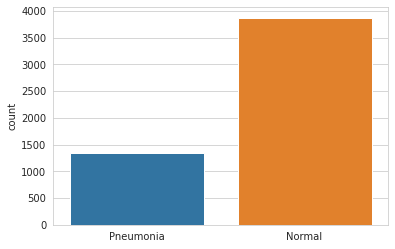

In [ ]:
l = []
for i in train:
  if(i[1] == 0):
    l.append("Pneumonia")
  else:
    l.append("Normal")
sns.set_style('whitegrid')
sns.countplot(l)

Below is a function to show arbitray number of normal or pneumonia images subject to the arguments passed

In [ ]:
def show_sample_images (number, normal=True):
  plt.figure(figsize=(12,12))
  if normal == True:
    for n in range(number):
      normal_img = os.listdir(train_n_path)[n]
      normal_img_address = train_n_path+normal_img
      normal_load = Image.open(normal_img_address)
      ax = plt.subplot(number/2,number/2,n+1)
      plt.imshow(normal_load, cmap ='gray')
      plt.title("NORMAL")
  else:
    for n in range(number):
      pneumonia_img = os.listdir(train_p_path)[n]
      pneumonia_img_address = train_p_path+pneumonia_img
      pneumonia_load = Image.open(pneumonia_img_address)
      ax = plt.subplot(number/2,number/2,n+1)
      plt.imshow(pneumonia_load, cmap ='gray')
      plt.title("PNEUMONIA")

  plt.axis("off")

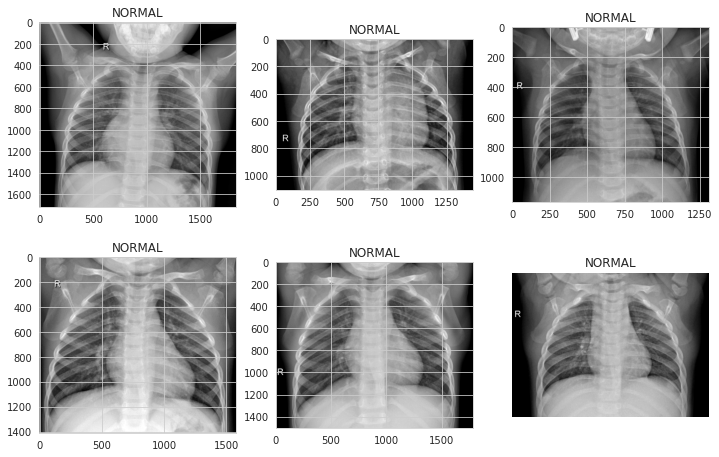

In [ ]:
# Show normal images
show_sample_images(6)

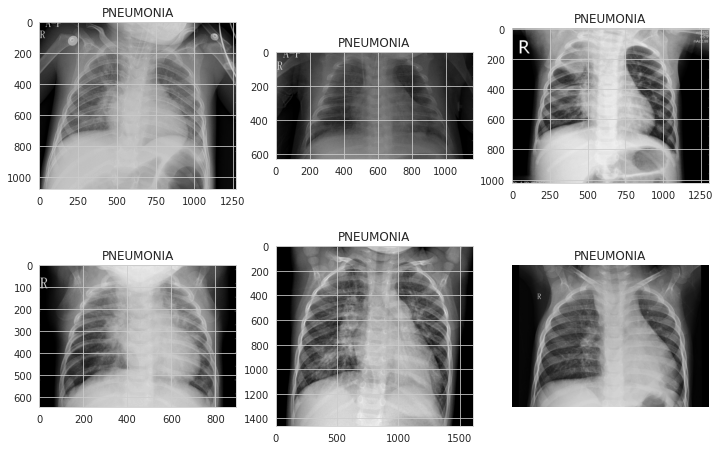

In [ ]:
# Show pneumonia images
show_sample_images(6,False)

histogram equalization improves images contrast for better visualisation. 

In [ ]:
from skimage import exposure

In [ ]:
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq

In [ ]:
def expose_image(Normal=True):
  if Normal==True:
    # Choose normal random image: generate random number between 1 and the number of normal images in the training set
    random_img_ind= np.random.randint(0,len(os.listdir(train_n_path)))
    # image file name
    img_expose_name = os.listdir(train_n_path)[random_img_ind]

    # path to the image
    imp_expose_address = train_n_path+img_expose_name

    # load image
    img_expose = Image.open(img_expose_address)
    img = np.asarray(img_expose)
    image_eq = equlize_hist_(img)
    figure1 = plt.figure(figsize= (16,16))
    img_1 = figure1.add_subplot(1,2,1)
    img_plot = plt.imshow(img, cmap = 'gray')
    img_1.set_title('Normal')
    plt.axis("off")

    img2 = figure1.add_subplot(1, 2, 2)
    img_plot = plt.imshow(image_eq, cmap = 'gray')
    img2.set_title('Normal after HE')
    plt.axis("off")
  else:
    # Choose normal random image: generate random number between 1 and the number of normal images in the training set
    random_img_ind= np.random.randint(0,len(os.listdir(train_p_path)))
    # image file name
    img_expose_name = os.listdir(train_p_path)[random_img_ind]

    # path to the image
    img_expose_address = train_p_path+img_expose_name

    # load mage
    img_expose = Image.open(img_expose_address)
    img = np.asarray(img_expose)
    image_eq = equlize_hist_(img)
    figure1 = plt.figure(figsize= (16,16))
    img_1 = figure1.add_subplot(1,2,1)
    img_plot = plt.imshow(img, cmap = 'gray')
    img_1.set_title('Pneumonia')
    plt.axis("off")
    
    img2 = figure1.add_subplot(1, 2, 2)
    img_plot = plt.imshow(image_eq, cmap = 'gray')
    img2.set_title('Pneumonia after HE')
    plt.axis("off")

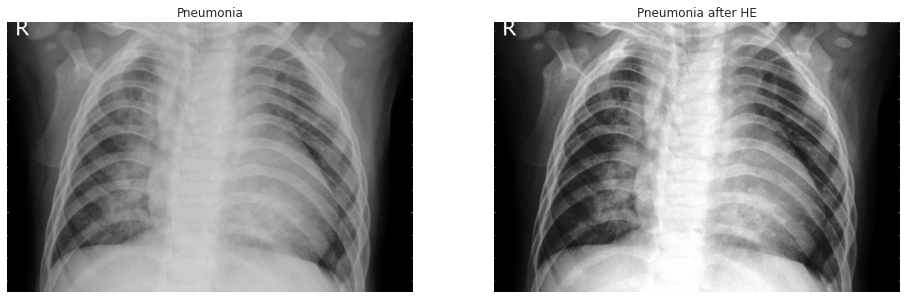

In [ ]:
# expose_image() will show random normal image
expose_image(False)

# Build CNN Model

First step, we want to arrange the data in different constructs (x_train, y_train, x_test, y_test,
x_val,y_val), etc. . . ):

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

* the feature variable is the images
* the label variable is the 0 and 1 (Normal and Pneumonia)

In [ ]:
print(f'Number of images in the training set is {len(x_train)}')

Number of images in the training set is 5216


In [ ]:
# Normalise the data
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

Resize the arrays for deep learning

In [ ]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

The resized data is now a numpy vector array

<b>Image Data Generator</b> In this part, for building the CNN model. First,  whilst making the use of Kerass
ImageDatGenerator to perform data augmentation, data augmentation help improve the performance of the model by generating more
data via applying a geometric transformation (e.g. translation, rotation, scaling, shearing, etc. . . )
to existing data/ images.

Data Augmentation is used to avoid any overfitting in the project, this is done by altering the data with small transformations for reproducing the variations.

Applying a couple of the following transformations to the training data can easily double or even triple the number of training images and to develop a robust model





In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#n_steps = int(math.ceil(1. * training_set.samples / batch_size))

# data generator
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range = 30, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
        horizontal_flip = True, # randomly flip images
        vertical_flip=False) # randomly flip images

datagen.fit(x_train)

# Running the model and classification

<b>CNN Model</b> The code below defines a CNN model. Notice, that this is almost similar to most of
the architecture to other related work in CNN pneumonia detection with some Conv layers, followed by pooling and drop out,
repeated a few times. A couple of notes about the code below:

1. Notice the BatchNormalization layer that is added to the model. This is
often used to speed up the training process and make it more stable. It
does so by normalizing the inputs from hidden layers
2. The Droput layer: is used to prevent overfitting of the model. It does this by setting some
input units to 0 during the training process (e.g. switching off some neurons in the network)
3. The MaxPooling layer: Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' ,
input_shape = (img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" ,
              loss = 'binary_crossentropy' , 
              metrics = ['accuracy'])

In [ ]:
# model summary (see the number of trainable parameters)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50, 64)       2

How the learning rate reduction variable works is when it finds a plateau in the epochs class curve that is a place where at the increase of epochs, the gradient is not increasing and have reached a straight line where the gradient is 0 but isn't a minima, the loss is reduced so it can move on to different parts of the gradient.

The history variable fits the CNN model, the use of 25 epochs felt more natural and can likely lead to better results, However the more the epochs the longer the model will take to run.

In [ ]:
batch_size = 32
n_epochs = 25

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
)

Epoch 1/25
163/163 [==============================] - 97s 586ms/step - loss: 0.2644 - accuracy: 0.9016 - val_loss: 43.4011 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/25
163/163 [==============================] - 97s 595ms/step - loss: 0.2178 - accuracy: 0.9189 - val_loss: 23.2631 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/25
163/163 [==============================] - 95s 585ms/step - loss: 0.2081 - accuracy: 0.9248 - val_loss: 0.5918 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/25
163/163 [==============================] - 96s 588ms/step - loss: 0.2044 - accuracy: 0.9314 - val_loss: 1.7740 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/25
163/163 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9396
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 96s 591ms/step - loss: 0.1848 - accuracy: 0.9396 - val_loss: 2.7719 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/25
163/163 [===========================

<b>Analyse Results</b>

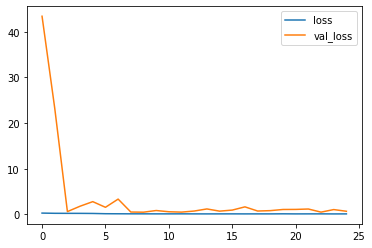

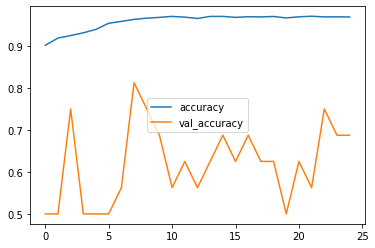

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()

Check the testing accuracy/ loss

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 112ms/step - loss: 0.2935 - accuracy: 0.9151
Loss of the model is -  0.293488085269928
20/20 [==============================] - 2s 117ms/step - loss: 0.2935 - accuracy: 0.9151
Accuracy of the model is -  91.50640964508057 %


Save the model and make some predictions:

In [ ]:
from tensorflow.keras.models import load_model
model.save('CNN_PNEUMONIA.h5') #
predictions =  model.predict(x_test)
for i in range(len(predictions)):
  predictions[i] = 1 if predictions[i]>0.5 else 0
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 [==============================] - 3s 117ms/step


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

precision recall f1-score

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.96      0.93       390
   Normal (Class 1)       0.93      0.84      0.88       234

           accuracy                           0.92       624
          macro avg       0.92      0.90      0.91       624
       weighted avg       0.92      0.92      0.91       624



confusion matrix

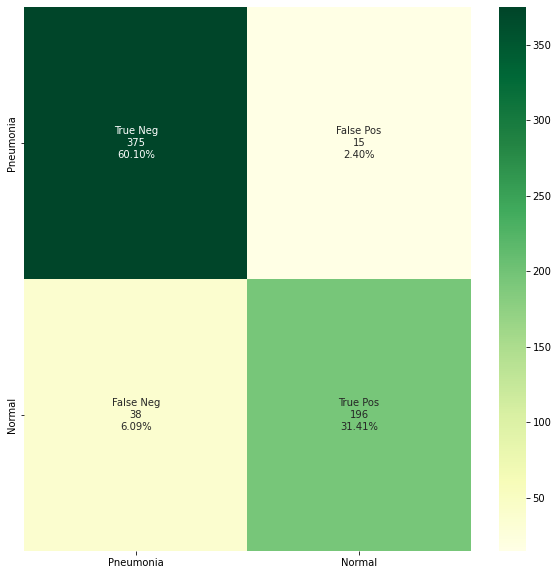

In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize = (10,10))
classes = ['Pneumonia','Normal']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
)


In [ ]:
# store actual class labels and predicted ones in a dataframe
results = pd.DataFrame({'Actual':y_test,'Predicted':predictions})

incorrect_df = results[results.Actual!=results.Predicted]
incorrect_df.head()

,Actual,Predicted
19,0,1.0
36,0,1.0
44,0,1.0
61,0,1.0
65,0,1.0


In [ ]:
# manual calculation of of results
print(f'Accuracy is {round((results.shape[0]-incorrect_df.shape[0])/results.shape[0],2)*100} %')

Accuracy is 92.0 %


In [ ]:
#show some examples
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

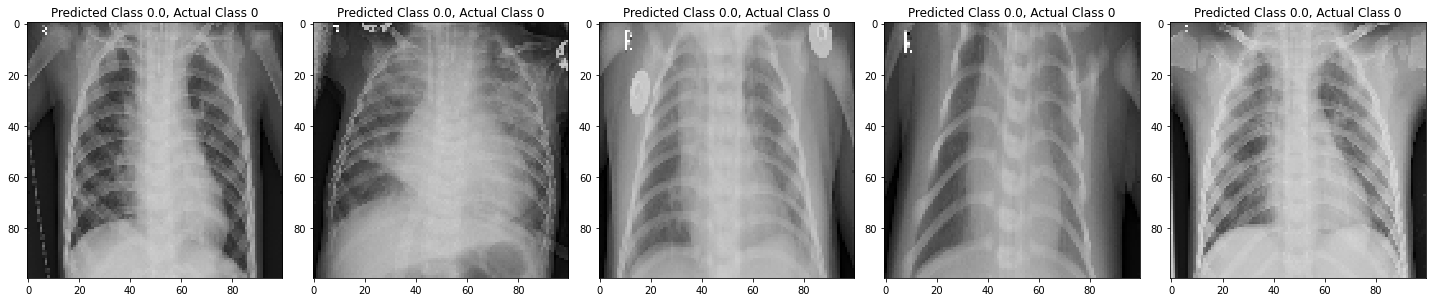

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in correct[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1


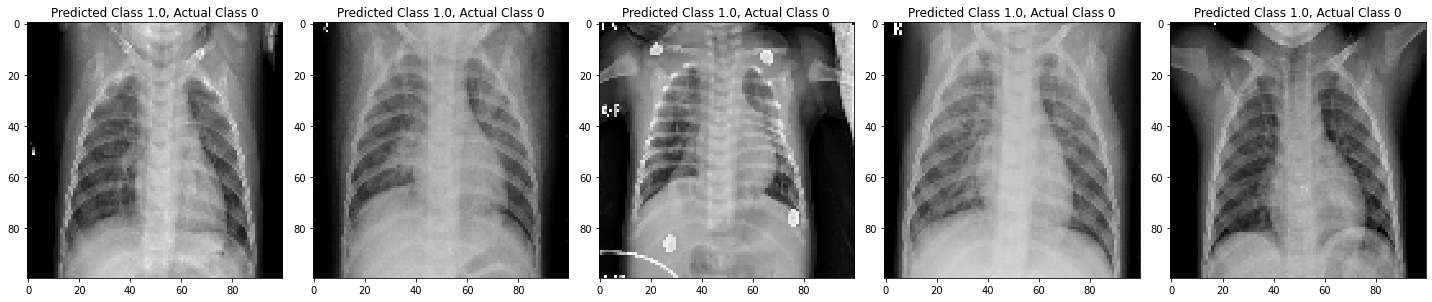

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Transfer Learning and Feature Extraction


<b> Pre-trained models</b>
Here, a pre-trained model is used to perform classification (Transfer Learning). Various models
such as VGG16, XCeption, etc. . . can be used. In this example, ResNet152 V2 wil be used which is available on the Keras Package. Also notice that these
models have been trained using large number of images.

ResNet152 V2 acts as a feature extraction model and has many advantages as a pre-trained model in accelerating training and converging to high accuracy rapidly. Most work have used VGG16 and XCeption the most commonly so ResNet152 V2 was chosen to see whether or not the performance of detecting and diagnosing pneumonia improves or is any effective.

instantiate a ResNet152 V2 model pre-loaded with weights trained on ImageNet. By specifying the <b>include_top=False</b> argument, then load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
from keras.applications.vgg16 import VGG16 #(if you want to use VG16)
from keras.applications.inception_v3 import InceptionV3

Freezing the convolutional base to use as a feature extractor. Additionally, add a classifier on top of it and train the top-level classifier.

Freezing the convolutional base is important before compiling and training the model. Setting the layer.trainable = False prevents weights in a given layer from updated during the training process. Since ResNet 152 has many layers setting the whole models trainable flag to False will freeze them all.

In [ ]:
# Notice 1st time this is being run, it will download the weights for the ResNet model

tf.keras.backend.clear_session()

base_model = tf.keras.applications.ResNet152V2(
        weights='imagenet',
        input_shape=(img_size, img_size, 3),
        include_top=False)

# freeze the layers
base_model.trainable = False


234545216/234545216 [==============================] - 2s 0us/step


For generating the predictions from the block of features over the spatial locations, using the layers.GlobalAveragePooling2D layer converts the features to a single element vector per image.

Applying the layers.Dense converts the features into a single prediction per image.

The Droput layer prevents overfitting of the model. It does this by setting some input units to 0 during the training process

Then build the model by chaining together the data augmentation, rescaling base_model and feature extractor layers using Keras Functional API.

In [ ]:
def get_pretrained():

        #Input shape = [width, height, color channels]
        inputs = layers.Input(shape=(img_size,img_size, 3))
        x = base_model(inputs)

        # Head
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.1)(x)

        #Final Layer (Output)
        output = layers.Dense(1, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=[inputs], outputs=output)

        return model

Then compile the model before training it, as there is two classes, the use of the binary cossentropy loss is required since the model provides a linear output.

In [ ]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005),
                         metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
history_tl = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
            epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
            callbacks = [learning_rate_reduction],
            steps_per_epoch = x_train.shape[0]/batch_size
)

Epoch 1/25
163/163 [==============================] - ETA: 0s - loss: 0.4209 - binary_accuracy: 0.8142

163/163 [==============================] - 309s 2s/step - loss: 0.4209 - binary_accuracy: 0.8142 - val_loss: 0.6411 - val_binary_accuracy: 0.8125 - lr: 5.0000e-05
Epoch 2/25
163/163 [==============================] - ETA: 0s - loss: 0.2907 - binary_accuracy: 0.8756

163/163 [==============================] - 295s 2s/step - loss: 0.2907 - binary_accuracy: 0.8756 - val_loss: 0.7130 - val_binary_accuracy: 0.6875 - lr: 5.0000e-05
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 0.2592 - binary_accuracy: 0.8932

163/163 [==============================] - 298s 2s/step - loss: 0.2592 - binary_accuracy: 0.8932 - val_loss: 0.7451 - val_binary_accuracy: 0.6250 - lr: 5.0000e-05
Epoch 4/25
163/163 [==============================] - ETA: 0s - loss: 0.2446 - binary_accuracy: 0.9011

163/163 [==============================] - 296s 2s/step - loss: 0.2446 - binary_accuracy: 0.9011 - val_loss: 0.5652 - val_binary_accuracy: 0.8125 - lr: 5.0000e-05
Epoch 5/25
163/163 [==============================] - ETA: 0s - loss: 0.2278 - binary_accuracy: 0.9080

163/163 [==============================] - 296s 2s/step - loss: 0.2278 - binary_accuracy: 0.9080 - val_loss: 0.6824 - val_binary_accuracy: 0.7500 - lr: 5.0000e-05
Epoch 6/25
163/163 [==============================] - ETA: 0s - loss: 0.2201 - binary_accuracy: 0.9114

163/163 [==============================] - 296s 2s/step - loss: 0.2201 - binary_accuracy: 0.9114 - val_loss: 0.6985 - val_binary_accuracy: 0.6250 - lr: 5.0000e-05
Epoch 7/25
163/163 [==============================] - ETA: 0s - loss: 0.2090 - binary_accuracy: 0.9132

163/163 [==============================] - 300s 2s/step - loss: 0.2090 - binary_accuracy: 0.9132 - val_loss: 0.6797 - val_binary_accuracy: 0.6875 - lr: 5.0000e-05
Epoch 8/25
163/163 [==============================] - ETA: 0s - loss: 0.2016 - binary_accuracy: 0.9204

163/163 [==============================] - 298s 2s/step - loss: 0.2016 - binary_accuracy: 0.9204 - val_loss: 0.6173 - val_binary_accuracy: 0.6875 - lr: 5.0000e-05
Epoch 9/25
163/163 [==============================] - ETA: 0s - loss: 0.1985 - binary_accuracy: 0.9208

163/163 [==============================] - 296s 2s/step - loss: 0.1985 - binary_accuracy: 0.9208 - val_loss: 1.0894 - val_binary_accuracy: 0.6250 - lr: 5.0000e-05
Epoch 10/25
163/163 [==============================] - ETA: 0s - loss: 0.1982 - binary_accuracy: 0.9195

163/163 [==============================] - 297s 2s/step - loss: 0.1982 - binary_accuracy: 0.9195 - val_loss: 0.7739 - val_binary_accuracy: 0.6250 - lr: 5.0000e-05
Epoch 11/25
163/163 [==============================] - ETA: 0s - loss: 0.1806 - binary_accuracy: 0.9291

163/163 [==============================] - 296s 2s/step - loss: 0.1806 - binary_accuracy: 0.9291 - val_loss: 0.6157 - val_binary_accuracy: 0.7500 - lr: 5.0000e-05
Epoch 12/25
163/163 [==============================] - ETA: 0s - loss: 0.1896 - binary_accuracy: 0.9229

163/163 [==============================] - 296s 2s/step - loss: 0.1896 - binary_accuracy: 0.9229 - val_loss: 0.7217 - val_binary_accuracy: 0.6875 - lr: 5.0000e-05
Epoch 13/25
163/163 [==============================] - ETA: 0s - loss: 0.1896 - binary_accuracy: 0.9283

163/163 [==============================] - 296s 2s/step - loss: 0.1896 - binary_accuracy: 0.9283 - val_loss: 0.7660 - val_binary_accuracy: 0.6875 - lr: 5.0000e-05
Epoch 14/25
163/163 [==============================] - ETA: 0s - loss: 0.1888 - binary_accuracy: 0.9248

163/163 [==============================] - 297s 2s/step - loss: 0.1888 - binary_accuracy: 0.9248 - val_loss: 0.6348 - val_binary_accuracy: 0.6250 - lr: 5.0000e-05
Epoch 15/25
163/163 [==============================] - ETA: 0s - loss: 0.1783 - binary_accuracy: 0.9277

163/163 [==============================] - 299s 2s/step - loss: 0.1783 - binary_accuracy: 0.9277 - val_loss: 0.6739 - val_binary_accuracy: 0.6250 - lr: 5.0000e-05
Epoch 16/25
163/163 [==============================] - ETA: 0s - loss: 0.1783 - binary_accuracy: 0.9270

163/163 [==============================] - 298s 2s/step - loss: 0.1783 - binary_accuracy: 0.9270 - val_loss: 0.5945 - val_binary_accuracy: 0.6250 - lr: 5.0000e-05
Epoch 17/25
163/163 [==============================] - ETA: 0s - loss: 0.1794 - binary_accuracy: 0.9262

163/163 [==============================] - 297s 2s/step - loss: 0.1794 - binary_accuracy: 0.9262 - val_loss: 0.5708 - val_binary_accuracy: 0.7500 - lr: 5.0000e-05
Epoch 18/25
163/163 [==============================] - ETA: 0s - loss: 0.1661 - binary_accuracy: 0.9333

163/163 [==============================] - 295s 2s/step - loss: 0.1661 - binary_accuracy: 0.9333 - val_loss: 0.5035 - val_binary_accuracy: 0.7500 - lr: 5.0000e-05
Epoch 19/25
163/163 [==============================] - ETA: 0s - loss: 0.1747 - binary_accuracy: 0.9321

163/163 [==============================] - 296s 2s/step - loss: 0.1747 - binary_accuracy: 0.9321 - val_loss: 0.4095 - val_binary_accuracy: 0.8125 - lr: 5.0000e-05
Epoch 20/25
163/163 [==============================] - ETA: 0s - loss: 0.1709 - binary_accuracy: 0.9296

163/163 [==============================] - 297s 2s/step - loss: 0.1709 - binary_accuracy: 0.9296 - val_loss: 0.8668 - val_binary_accuracy: 0.6250 - lr: 5.0000e-05
Epoch 21/25
163/163 [==============================] - ETA: 0s - loss: 0.1664 - binary_accuracy: 0.9354

163/163 [==============================] - 297s 2s/step - loss: 0.1664 - binary_accuracy: 0.9354 - val_loss: 0.5798 - val_binary_accuracy: 0.8125 - lr: 5.0000e-05
Epoch 22/25
163/163 [==============================] - ETA: 0s - loss: 0.1676 - binary_accuracy: 0.9333

163/163 [==============================] - 297s 2s/step - loss: 0.1676 - binary_accuracy: 0.9333 - val_loss: 0.7908 - val_binary_accuracy: 0.6875 - lr: 5.0000e-05
Epoch 23/25
163/163 [==============================] - ETA: 0s - loss: 0.1647 - binary_accuracy: 0.9369

163/163 [==============================] - 287s 2s/step - loss: 0.1647 - binary_accuracy: 0.9369 - val_loss: 0.8840 - val_binary_accuracy: 0.6250 - lr: 5.0000e-05
Epoch 24/25
163/163 [==============================] - ETA: 0s - loss: 0.1681 - binary_accuracy: 0.9312

163/163 [==============================] - 286s 2s/step - loss: 0.1681 - binary_accuracy: 0.9312 - val_loss: 0.7756 - val_binary_accuracy: 0.7500 - lr: 5.0000e-05
Epoch 25/25
163/163 [==============================] - ETA: 0s - loss: 0.1687 - binary_accuracy: 0.9344

163/163 [==============================] - 287s 2s/step - loss: 0.1687 - binary_accuracy: 0.9344 - val_loss: 0.6340 - val_binary_accuracy: 0.7500 - lr: 5.0000e-05


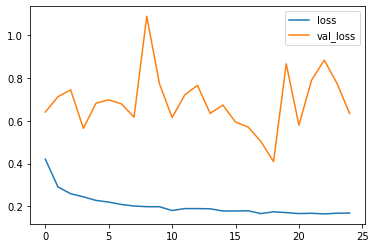

In [ ]:
losses = pd.DataFrame(model_pretrained.history.history)
losses[['loss','val_loss']].plot()

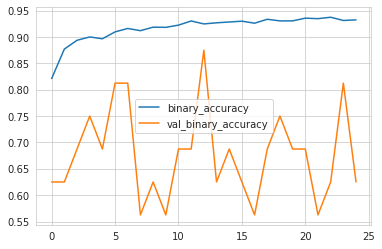

In [ ]:
losses[['binary_accuracy','val_binary_accuracy']].plot()

In [ ]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 35s 2s/step - loss: 0.3095 - binary_accuracy: 0.8750
Loss of the model is -  0.30951887369155884
20/20 [==============================] - 33s 2s/step - loss: 0.3095 - binary_accuracy: 0.8750
Accuracy of the model is -  87.5 %


In [ ]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

20/20 [==============================] - 38s 2s/step


In [ ]:
print(classification_report(y_test, pred_labels, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.88      0.93      0.90       390
   Normal (Class 1)       0.87      0.78      0.82       234

           accuracy                           0.88       624
          macro avg       0.87      0.86      0.86       624
       weighted avg       0.87      0.88      0.87       624



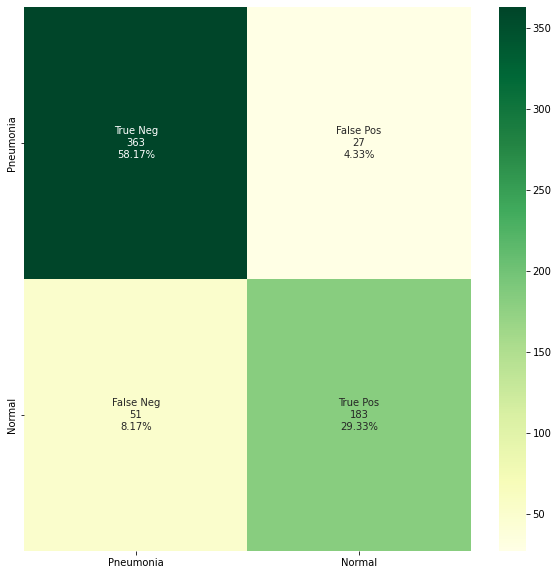

In [ ]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
            xticklabels = classes,yticklabels = classes)

In [ ]:
cf_matrix

array([[363,  27],
       [ 51, 183]])

# Fine-Tuning

For Fine-tuning models
Notice that while using pre-trained models, the weights have not been trained, or retrained any
of the ResNet layers. Simply put, there has been updates of the input and output of the models, while
keeping all layers of the pre-trained models frozen. Although this is useful, in some cases you
need to train some of the layers (update the weights of the model), and this is what is called finetuning the models. Here, the process will unfreeze some layers and retrain. Note also, that mostly often keep lower layers frozen, because these capture generic features that may be shared with
most images.

the base_model needs to unfreeze and then set the bottom layers to be untrainable. Then recomplile the model and resume the training.

since the model for training will take much larger, the pretrained weights are readapted as using a lower learning rate in this stage is important or the consequence is that the model could overfit quickly.

In [ ]:
#Fine tunning
base_model.trainable = True

# Retrain the last 10 layers (all lower layers will be kept frozen)
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
model_pretrained.compile(loss='binary_crossentropy'
      , optimizer = tf.keras.optimizers.Adam(learning_rate=0.000002), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
history_ft = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                                  epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                                  callbacks = [learning_rate_reduction],
                                  steps_per_epoch = x_train.shape[0]/batch_size
)

Epoch 1/25
163/163 [==============================] - ETA: 0s - loss: 0.2706 - binary_accuracy: 0.8999

163/163 [==============================] - 341s 2s/step - loss: 0.2706 - binary_accuracy: 0.8999 - val_loss: 0.6388 - val_binary_accuracy: 0.6250 - lr: 2.0000e-06
Epoch 2/25
163/163 [==============================] - ETA: 0s - loss: 0.2358 - binary_accuracy: 0.9143

163/163 [==============================] - 326s 2s/step - loss: 0.2358 - binary_accuracy: 0.9143 - val_loss: 0.4666 - val_binary_accuracy: 0.7500 - lr: 2.0000e-06
Epoch 3/25
163/163 [==============================] - ETA: 0s - loss: 0.2282 - binary_accuracy: 0.9139

163/163 [==============================] - 328s 2s/step - loss: 0.2282 - binary_accuracy: 0.9139 - val_loss: 0.4469 - val_binary_accuracy: 0.8125 - lr: 2.0000e-06
Epoch 4/25
163/163 [==============================] - ETA: 0s - loss: 0.2160 - binary_accuracy: 0.9204

163/163 [==============================] - 326s 2s/step - loss: 0.2160 - binary_accuracy: 0.9204 - val_loss: 0.6336 - val_binary_accuracy: 0.6875 - lr: 2.0000e-06
Epoch 5/25
163/163 [==============================] - ETA: 0s - loss: 0.2016 - binary_accuracy: 0.9239

163/163 [==============================] - 326s 2s/step - loss: 0.2016 - binary_accuracy: 0.9239 - val_loss: 0.4811 - val_binary_accuracy: 0.7500 - lr: 2.0000e-06
Epoch 6/25
163/163 [==============================] - ETA: 0s - loss: 0.2046 - binary_accuracy: 0.9183

163/163 [==============================] - 325s 2s/step - loss: 0.2046 - binary_accuracy: 0.9183 - val_loss: 0.5018 - val_binary_accuracy: 0.6875 - lr: 2.0000e-06
Epoch 7/25
163/163 [==============================] - ETA: 0s - loss: 0.1932 - binary_accuracy: 0.9287

163/163 [==============================] - 326s 2s/step - loss: 0.1932 - binary_accuracy: 0.9287 - val_loss: 0.4573 - val_binary_accuracy: 0.7500 - lr: 2.0000e-06
Epoch 8/25
163/163 [==============================] - ETA: 0s - loss: 0.2037 - binary_accuracy: 0.9233

163/163 [==============================] - 326s 2s/step - loss: 0.2037 - binary_accuracy: 0.9233 - val_loss: 0.4652 - val_binary_accuracy: 0.8125 - lr: 2.0000e-06
Epoch 9/25
163/163 [==============================] - ETA: 0s - loss: 0.1982 - binary_accuracy: 0.9231

163/163 [==============================] - 323s 2s/step - loss: 0.1982 - binary_accuracy: 0.9231 - val_loss: 0.6898 - val_binary_accuracy: 0.5625 - lr: 2.0000e-06
Epoch 10/25
163/163 [==============================] - ETA: 0s - loss: 0.2017 - binary_accuracy: 0.9208

163/163 [==============================] - 331s 2s/step - loss: 0.2017 - binary_accuracy: 0.9208 - val_loss: 0.4838 - val_binary_accuracy: 0.7500 - lr: 2.0000e-06
Epoch 11/25
163/163 [==============================] - ETA: 0s - loss: 0.1787 - binary_accuracy: 0.9275

163/163 [==============================] - 329s 2s/step - loss: 0.1787 - binary_accuracy: 0.9275 - val_loss: 0.7443 - val_binary_accuracy: 0.6250 - lr: 2.0000e-06
Epoch 12/25
163/163 [==============================] - ETA: 0s - loss: 0.1917 - binary_accuracy: 0.9271

163/163 [==============================] - 328s 2s/step - loss: 0.1917 - binary_accuracy: 0.9271 - val_loss: 0.6046 - val_binary_accuracy: 0.6250 - lr: 2.0000e-06
Epoch 13/25
163/163 [==============================] - ETA: 0s - loss: 0.1826 - binary_accuracy: 0.9275

163/163 [==============================] - 331s 2s/step - loss: 0.1826 - binary_accuracy: 0.9275 - val_loss: 0.8923 - val_binary_accuracy: 0.6250 - lr: 2.0000e-06
Epoch 14/25
163/163 [==============================] - ETA: 0s - loss: 0.1900 - binary_accuracy: 0.9283

163/163 [==============================] - 332s 2s/step - loss: 0.1900 - binary_accuracy: 0.9283 - val_loss: 0.4615 - val_binary_accuracy: 0.6875 - lr: 2.0000e-06
Epoch 15/25
163/163 [==============================] - ETA: 0s - loss: 0.1805 - binary_accuracy: 0.9277

163/163 [==============================] - 330s 2s/step - loss: 0.1805 - binary_accuracy: 0.9277 - val_loss: 0.7316 - val_binary_accuracy: 0.6875 - lr: 2.0000e-06
Epoch 16/25
163/163 [==============================] - ETA: 0s - loss: 0.1751 - binary_accuracy: 0.9367

163/163 [==============================] - 331s 2s/step - loss: 0.1751 - binary_accuracy: 0.9367 - val_loss: 0.6984 - val_binary_accuracy: 0.6875 - lr: 2.0000e-06
Epoch 17/25
163/163 [==============================] - ETA: 0s - loss: 0.1777 - binary_accuracy: 0.9316

163/163 [==============================] - 331s 2s/step - loss: 0.1777 - binary_accuracy: 0.9316 - val_loss: 0.7337 - val_binary_accuracy: 0.5625 - lr: 2.0000e-06
Epoch 18/25
163/163 [==============================] - ETA: 0s - loss: 0.1795 - binary_accuracy: 0.9298

163/163 [==============================] - 331s 2s/step - loss: 0.1795 - binary_accuracy: 0.9298 - val_loss: 0.4224 - val_binary_accuracy: 0.7500 - lr: 2.0000e-06
Epoch 19/25
163/163 [==============================] - ETA: 0s - loss: 0.1851 - binary_accuracy: 0.9264

163/163 [==============================] - 331s 2s/step - loss: 0.1851 - binary_accuracy: 0.9264 - val_loss: 0.6012 - val_binary_accuracy: 0.6250 - lr: 2.0000e-06
Epoch 20/25
163/163 [==============================] - ETA: 0s - loss: 0.1737 - binary_accuracy: 0.9300

163/163 [==============================] - 331s 2s/step - loss: 0.1737 - binary_accuracy: 0.9300 - val_loss: 0.5219 - val_binary_accuracy: 0.8125 - lr: 2.0000e-06
Epoch 21/25
163/163 [==============================] - ETA: 0s - loss: 0.1744 - binary_accuracy: 0.9302

163/163 [==============================] - 333s 2s/step - loss: 0.1744 - binary_accuracy: 0.9302 - val_loss: 0.5274 - val_binary_accuracy: 0.8125 - lr: 2.0000e-06
Epoch 22/25
163/163 [==============================] - ETA: 0s - loss: 0.1703 - binary_accuracy: 0.9321

163/163 [==============================] - 334s 2s/step - loss: 0.1703 - binary_accuracy: 0.9321 - val_loss: 0.3806 - val_binary_accuracy: 0.8125 - lr: 2.0000e-06
Epoch 23/25
163/163 [==============================] - ETA: 0s - loss: 0.1672 - binary_accuracy: 0.9325

163/163 [==============================] - 334s 2s/step - loss: 0.1672 - binary_accuracy: 0.9325 - val_loss: 0.3251 - val_binary_accuracy: 0.8125 - lr: 2.0000e-06
Epoch 24/25
163/163 [==============================] - ETA: 0s - loss: 0.1679 - binary_accuracy: 0.9348

163/163 [==============================] - 332s 2s/step - loss: 0.1679 - binary_accuracy: 0.9348 - val_loss: 0.4603 - val_binary_accuracy: 0.7500 - lr: 2.0000e-06
Epoch 25/25
163/163 [==============================] - ETA: 0s - loss: 0.1705 - binary_accuracy: 0.9329

163/163 [==============================] - 332s 2s/step - loss: 0.1705 - binary_accuracy: 0.9329 - val_loss: 0.8163 - val_binary_accuracy: 0.6875 - lr: 2.0000e-06


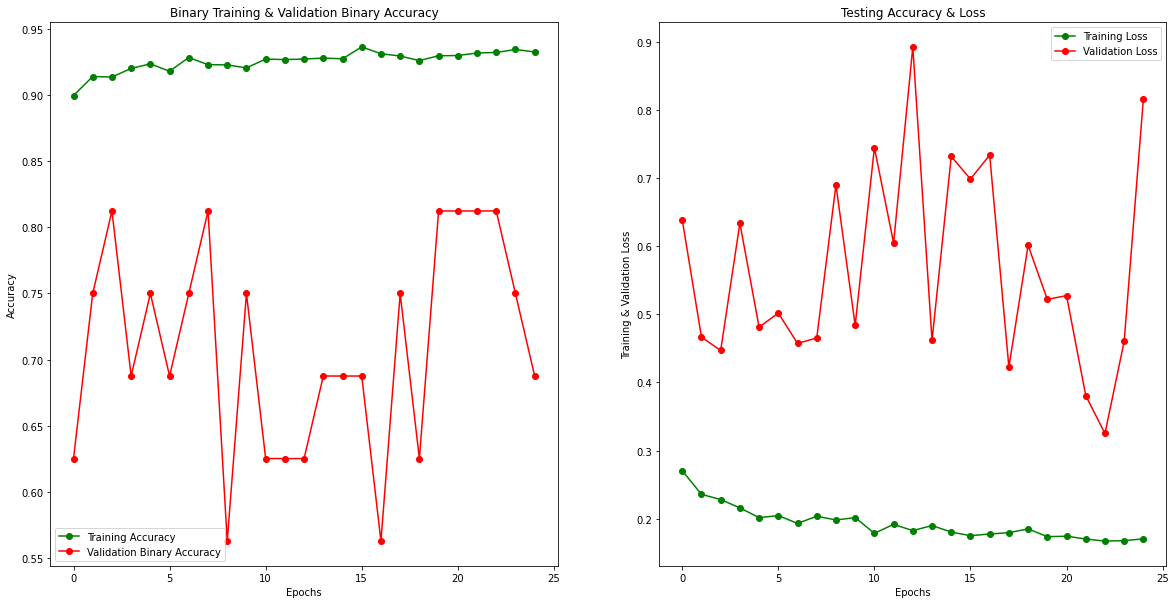

In [ ]:
epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history_ft.history['binary_accuracy']
train_loss = history_ft.history['loss']
val_acc = history_ft.history['val_binary_accuracy']
val_loss = history_ft.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Binary Accuracy')
ax[0].set_title('Binary Training & Validation Binary Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 38s 2s/step - loss: 0.3077 - binary_accuracy: 0.8798
Loss of the model is -  0.3076862096786499
20/20 [==============================] - 34s 2s/step - loss: 0.3077 - binary_accuracy: 0.8798
Accuracy of the model is -  87.9807710647583 %


In [ ]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

20/20 [==============================] - 39s 2s/step


In [ ]:
print(classification_report(y_test, pred_labels, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.87      0.96      0.91       390
   Normal (Class 1)       0.91      0.75      0.82       234

           accuracy                           0.88       624
          macro avg       0.89      0.85      0.87       624
       weighted avg       0.88      0.88      0.88       624



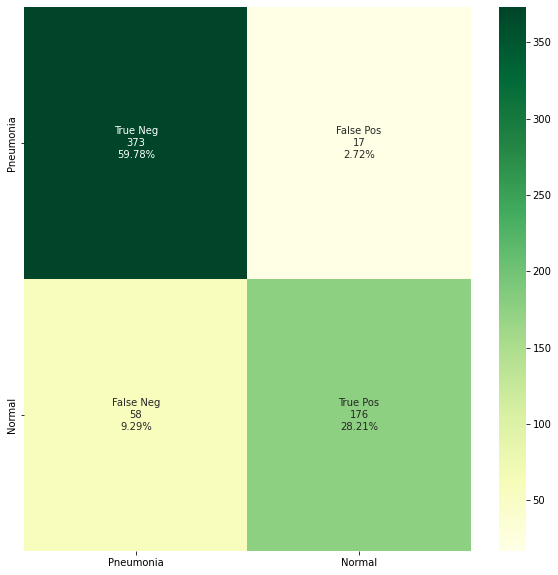

In [ ]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]          
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
            xticklabels = classes,yticklabels = classes)

# Comparing the results

Simple bar charts for comparing the metrices for detecting and diagnosing pneumonia

<b> Bar chart for Accuracy </b>

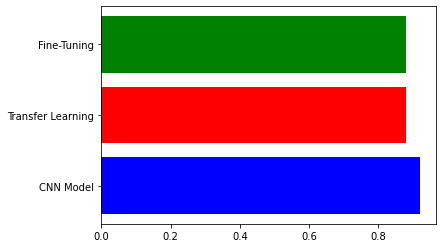

In [ ]:
cnns = np.array(["CNN Model", "Transfer Learning", "Fine-Tuning"])
numbers = np.array([0.92, 0.88, 0.88])

plt.barh(cnns, numbers, color=('blue', 'red', 'green'))
plt.show()

<b> Bar chart for Precision</b>

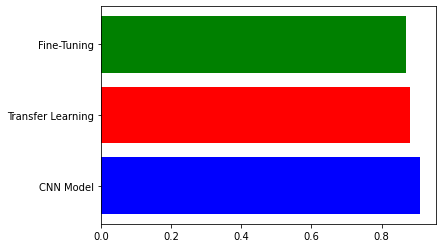

In [ ]:
cnns = np.array(["CNN Model", "Transfer Learning", "Fine-Tuning"])
numbers = np.array([0.91, 0.88, 0.87])

plt.barh(cnns, numbers, color=('blue', 'red', 'green'))
plt.show()

<b> Bar chart for Recall</b>

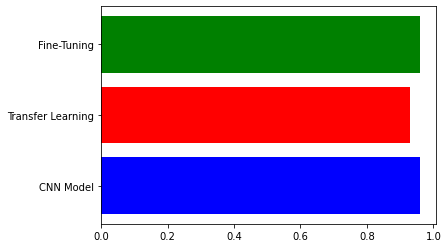

In [ ]:
cnns = np.array(["CNN Model", "Transfer Learning", "Fine-Tuning"])
numbers = np.array([0.96, 0.93, 0.96])

plt.barh(cnns, numbers, color=('blue', 'red', 'green'))
plt.show()


<b> Bar chart for F1-Score</b>

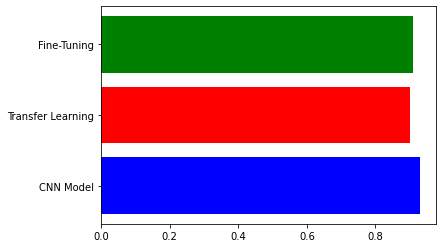

In [ ]:
cnns = np.array(["CNN Model", "Transfer Learning", "Fine-Tuning"])
numbers = np.array([0.93, 0.90, 0.91])

plt.barh(cnns, numbers, color=('blue', 'red', 'green'))
plt.show()

# Future Work and Limitations

If the project had extra time for further analysis and to apply other machine learning techniques, other future work can be done as described below:

* Explore other Classification such as NN, SVM, Naïve Bayes, etc
* Add more images to my dataset
* Check out other Image Augmentation techniques for balancing the datasets such as Image Augmentation With ImageDataGenerator, Horizontal and Vertical Shift Augmentation, Random Rotation Augmentation etc.
* Increase the RAM and see if performance is any better
* use a different computer to see if performance is any better
* explore other feature extraction techniques (HOG, SURF, SIFT etc.)
* apply random oversampling, undersampling and compare the performances
* apply other models for transfer learning such as Xception if performances have improved.
* find a solution to reduce the time to run epochs while training model
* analysis using metrics such as specificity and AUC-ROC